# Flight Price Prediction System


The objective of the study is to analyze the flight booking dataset obtained from the “Ease My Trip” website and to conduct various statistical hypothesis tests in order to get meaningful information from it. 'Easemytrip' is an internet platform for booking flight tickets, and hence a platform that potential passengers use to buy tickets. A thorough study of the data will aid in the discovery of valuable insights that will be of enormous value to passengers.

Dataset Link: [Flight Price Prediction](https://www.kaggle.com/datasets/jillanisofttech/flight-price-prediction-dataset?resource=download)

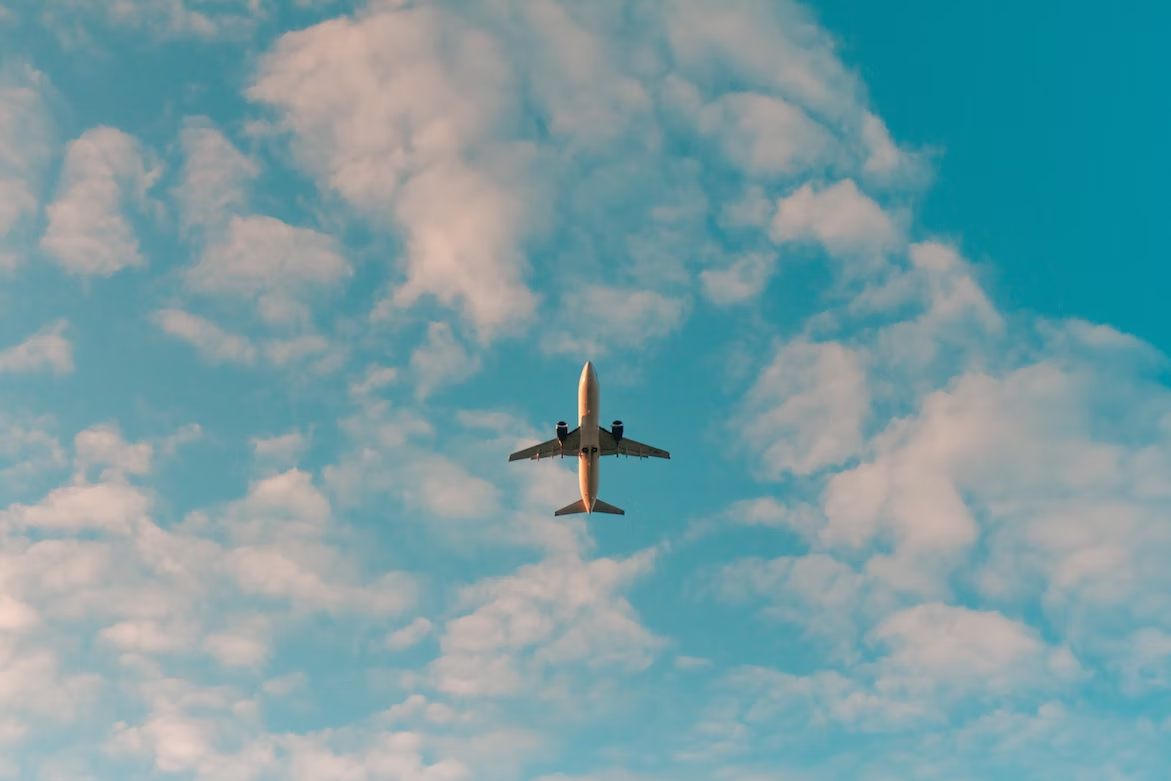



---



# Data Preprocessing

## Importing necessary libraries

In [3]:
import pandas as pd                 # Analyse Big Data
import seaborn as sns               # Statistical Graphs
import numpy as np                  # Mathematical Operations on Arrays
import matplotlib.pyplot as plt     # Create 2D Plots and plots
import datetime as dt               # Working with dates and times
from sklearn.model_selection import train_test_split, RandomizedSearchCV        # For Splitting into training and test dataset and getting best set of hyperparameters
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor         # Regressors to predict a continuous value (Price/Costs)
from ydata_profiling import ProfileReport      # For getting statistics on the dataset

## Reading the training data

In [4]:
flight_train = pd.read_excel('Data_Train.xlsx')
flight_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Checking shape of our data

In [5]:
flight_train.shape

(10683, 11)

## Checking null values in the dataset

In [6]:
flight_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## Checking the datatypes of our columns in the dataset

In [7]:
flight_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10683 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10683 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [8]:
flight_train.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [9]:
profile = ProfileReport(flight_train, title = 'Flights Data Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Preparation

## Merging Delhi and New Delhi


After looking at the profile report we saw that the `Destination` column has `Delhi` and `New Delhi` as different cities though they are same.

In [10]:
def newdelhi(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x
flight_train['Destination'] = flight_train['Destination'].apply(newdelhi)

## Making day and month columns from the `Date_of_Journey` column as datetime datatypes

Extracting day and month from the `Date_of_Journey` column and dropping the `Date_of_Journey` column

In [11]:
flight_train['Journey_Day'] = pd.to_datetime(flight_train['Date_of_Journey'],format='%d/%m/%Y').dt.day      # Extracting Journey Day
flight_train['Journey_Month'] = pd.to_datetime(flight_train['Date_of_Journey'],format='%d/%m/%Y').dt.month      # Extracting Journey Month

flight_train.drop('Date_of_Journey',inplace=True,axis=1)        # Dropping Column
flight_train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


## Extracting Hours and Minutes from Time

- We will extract Departure Hour and Departure Minutes from `Dep_Time`.
- And same will be done for `Arrival_Time`.
- And after that, we will drop both columns.

In [12]:
flight_train['Dep_Hour'] = pd.to_datetime(flight_train['Dep_Time']).dt.hour   # Extracting Hour
flight_train['Dep_Min'] = pd.to_datetime(flight_train['Dep_Time']).dt.minute    # Extracting Minutes
flight_train.drop('Dep_Time',axis=1,inplace=True)       # Dropping Column

flight_train['Arrival_Hour'] = pd.to_datetime(flight_train['Arrival_Time']).dt.hour     # Extracting Hour
flight_train['Arrival_Min'] = pd.to_datetime(flight_train['Arrival_Time']).dt.minute    # Extracting Minutes
flight_train.drop('Arrival_Time',axis=1,inplace=True)       # Dropping Column

flight_train.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


## Checking values in Duration Column

In [13]:
flight_train['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

Dropping the `Duration` column and extracting important info

In [14]:
duration = list(flight_train['Duration'])           # Creating a list of all the durations

for i in range(len(duration)):                      # Bringing the data to the same format
    if len(duration[i].split()) != 2:               # 30m can be written as 0h 30m
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:                              # Splitting the hours and minutes in 2 columns
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

flight_train['Duration_Hours'] = duration_hour         # Adding two columns
flight_train['Duration_Mins'] = duration_min

flight_train.drop('Duration',axis=1,inplace=True)       # Dropping Columns
flight_train.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [15]:
flight_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Source           10683 non-null  object
 2   Destination      10683 non-null  object
 3   Route            10683 non-null  object
 4   Total_Stops      10683 non-null  object
 5   Additional_Info  10683 non-null  object
 6   Price            10683 non-null  int64 
 7   Journey_Day      10683 non-null  int64 
 8   Journey_Month    10683 non-null  int64 
 9   Dep_Hour         10683 non-null  int64 
 10  Dep_Min          10683 non-null  int64 
 11  Arrival_Hour     10683 non-null  int64 
 12  Arrival_Min      10683 non-null  int64 
 13  Duration_Hours   10683 non-null  int64 
 14  Duration_Mins    10683 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 1.2+ MB


As we can see, we have prepared some of the columns in the dataset for model building

# Data Annotation

## Plotting Airline vs Price

In [16]:
sns.catplot(x='Airline',y='Price',data=flight_train.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

From the plot below we can infer that `Jet Airways Business` is the costliest airways.

## Encoding Categorical Variables

### Creating Dummy Columns out of the `Airline` Column

In [17]:
airline = flight_train[['Airline']]     
airline = pd.get_dummies(airline,drop_first=True)

As Airline is a categorical column, so we will make dummy columns out of it and store the same in the `airline` dataframe

In [18]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Airline_Air India                          10683 non-null  uint8
 1   Airline_GoAir                              10683 non-null  uint8
 2   Airline_IndiGo                             10683 non-null  uint8
 3   Airline_Jet Airways                        10683 non-null  uint8
 4   Airline_Jet Airways Business               10683 non-null  uint8
 5   Airline_Multiple carriers                  10683 non-null  uint8
 6   Airline_Multiple carriers Premium economy  10683 non-null  uint8
 7   Airline_SpiceJet                           10683 non-null  uint8
 8   Airline_Trujet                             10683 non-null  uint8
 9   Airline_Vistara                            10683 non-null  uint8
 10  Airline_Vistara Premium economy            106

Here we can see that the categorical column `Airline` is now converted into 'int' datatype

In [19]:
airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


## Plotting Source vs Price

In [20]:
sns.catplot(x='Source',y='Price',data=flight_train.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

The plot above says that if you are going from Bangalore, no matter where you have to pay the highest amount of money.

## Encoding Categorical Variables

### Creating Dummy Columns out of the `Source` Column

In [21]:
source = flight_train[['Source']]
source = pd.get_dummies(source,drop_first=True)

Storing the `int` datatype columns into the `source` dataframe

In [22]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Source_Chennai  10683 non-null  uint8
 1   Source_Delhi    10683 non-null  uint8
 2   Source_Kolkata  10683 non-null  uint8
 3   Source_Mumbai   10683 non-null  uint8
dtypes: uint8(4)
memory usage: 41.9 KB


Here we can see that the categorical column of `Source` is now converted into 'int' datatype

In [23]:
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


## Plotting Destination vs Price

In [24]:
sns.catplot(x='Destination',y='Price',data=flight_train.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

The plot abive says that if you are going to New Delhi, no matter from where, you have to pay the highest amount of money.

## Encoding Categorical Variables

### Creating Dummy COlumns out of the `Destination` Column

In [25]:
destination = flight_train[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)

Storing the dummy columns in a `destination` dataframe

In [26]:
destination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Destination_Cochin     10683 non-null  uint8
 1   Destination_Delhi      10683 non-null  uint8
 2   Destination_Hyderabad  10683 non-null  uint8
 3   Destination_Kolkata    10683 non-null  uint8
dtypes: uint8(4)
memory usage: 41.9 KB


We can see above that the categorical columns of `Destination` are now converted into 'int' datatype columns

In [27]:
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


## Dropping unwanted columns

In [28]:
flight_train.drop(['Route','Additional_Info'],inplace=True,axis=1)
flight_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1 stop,13302,1,3,16,50,21,35,4,45


## Checking values in `Total_Stops` column

In [29]:
flight_train['Total_Stops'].value_counts()

1 stop      5625
non-stop    3492
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

Converting labels into numbers in the `Total_Stops` column.

In [30]:
flight_train['Total_Stops'].replace({'non-stop': 0,'1 stop': 1,'2 stops': 2,'3 stops': 3,'4 stops':4},inplace=True)
flight_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


## Checking the shapes of our four dataframes now

In [31]:
print('Shape of airline Dataframe is: ',airline.shape)
print('Shape of source Dataframe is: ',source.shape)
print('Shape of destination Dataframe is: ',destination.shape)
print('Shape of Flight Train Dataset is: ',flight_train.shape)

Shape of airline Dataframe is:  (10683, 11)
Shape of source Dataframe is:  (10683, 4)
Shape of destination Dataframe is:  (10683, 4)
Shape of Flight Train Dataset is:  (10683, 13)


All these 4 data frames have the same number of rows, which means we can join them.

## Combining all the dataframes

Dropping the `Airline`, `Source`, `Destination` columns as we have already created dummy columns for them.

In [32]:
flight_train_new = pd.concat([flight_train,airline,source,destination],axis=1)
flight_train_new.drop(['Airline','Source','Destination'],axis=1,inplace=True)
flight_train_new.head()

,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Duration_Hours,Duration_Mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


In [33]:
flight_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Total_Stops                                10683 non-null  int64
 1   Price                                      10683 non-null  int64
 2   Journey_Day                                10683 non-null  int64
 3   Journey_Month                              10683 non-null  int64
 4   Dep_Hour                                   10683 non-null  int64
 5   Dep_Min                                    10683 non-null  int64
 6   Arrival_Hour                               10683 non-null  int64
 7   Arrival_Min                                10683 non-null  int64
 8   Duration_Hours                             10683 non-null  int64
 9   Duration_Mins                              10683 non-null  int64
 10  Airline_Air India                          106

# Training the Data

In [60]:
X = flight_train_new.drop('Price',axis=1)
X.head()
X.to_csv('data.csv')


In [35]:
X.isnull().sum()

Total_Stops                                  0
Journey_Day                                  0
Journey_Month                                0
Dep_Hour                                     0
Dep_Min                                      0
Arrival_Hour                                 0
Arrival_Min                                  0
Duration_Hours                               0
Duration_Mins                                0
Airline_Air India                            0
Airline_GoAir                                0
Airline_IndiGo                               0
Airline_Jet Airways                          0
Airline_Jet Airways Business                 0
Airline_Multiple carriers                    0
Airline_Multiple carriers Premium economy    0
Airline_SpiceJet                             0
Airline_Trujet                               0
Airline_Vistara                              0
Airline_Vistara Premium economy              0
Source_Chennai                               0
Source_Delhi 

Taking out train data labels

In [36]:
y = flight_train_new['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

## Checking Correlations between the columns again after Data Preparation

This is the correlation before creating dummy variable of column `Airline`, `Source`, `Destination` 

In [37]:
plt.figure(figsize=(15,10))
sns.heatmap(flight_train.corr(),cmap='viridis',annot=True)

C:\Users\himan\AppData\Local\Temp\ipykernel_16432\2824703777.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(flight_train.corr(),cmap='viridis',annot=True)


<AxesSubplot: >

This is the correlation after creating dummy variable of column `Airline`, `Source`, `Destination` which will lead in better accuracy score of the model.

In [38]:
plt.figure(figsize=(20,10))
sns.heatmap(flight_train_new.corr(),cmap='viridis',annot=True)

<AxesSubplot: >

# Train Test Split

We split the training and testing data set in the ratio of 7:3

70% of the data will be used for training the model 
30% of the data will be used for testing the accuracy of our built model

`random_state`=42  ensures that the splits that we generate are reproducible.
(i.e if in future we run our model again on the same dataset then we will be getting the same accuracy)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.30,random_state=42)

# Model Training

We will be training our dataset on 6 models:

- Linear Regression Model
- K Neighbours Resgressor
- Decision Tree Regressor
- Gradient Boosting Regressor
- XGB Regressor

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

In [41]:
lr = LinearRegression()

knn = KNeighborsRegressor()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

xgb = XGBRegressor()



model_list = [
    ('Linear Regression', lr),
    ('KNeighbors', knn),
    ('Decision Tree', dt),
    ('Random Forest', rf),
    ('Xboosting', xgb)
]

Predicting the values:

- Train Score
- Test Score
- MAE (Mean Absolute Error)
- MSE (Mean square error)
- RSME (Root Mean square error)

## Building a Dataframe for comparison between models

In [42]:
def simple_style(                                           # Function to style a basic dataframe
        s: pd.Series, true_css: str, false_css: str = ''
) -> np.ndarray:
    
    if s.name in ['MAE', 'MSE', 'RMSE']:
        return np.where(s ==  s.min(), true_css, false_css)     # It will color the minimum values of the MAE, MSE, RMSE from the comparisons
    else:
        return np.where(s ==  s.max(), true_css, false_css)     # It will color the maximum values of the Train and Test Score from the comparisons as we need better accuracy with low errors and deviations

In [43]:
def predict(model_lst, X_train, X_test, y_train, y_test):

    evalation_df = pd.DataFrame(data=None)              # Creating a dataframe
    prediction_lst = []                                 # Creating a list of predictions to store the different values of models
    model_name_lst = []
    
    for model_name, model in model_lst:                 # Iterating through the models list one by one
        model_evalation = []
        
        print('Running: {}'.format(model_name))
        model.fit(X_train,y_train)
        
        train_score= round(model.score(X_train,y_train), 2)     # Getting the Training Accuracy of the model
        model_evalation.append(train_score)

        predictions = model.predict(X_test)                     # Predicting the values from the model to get Testing Accuracy

        test_score= round(model.score(X_test,y_test), 2)        # Getting the Testing Accuracy of the model
        model_evalation.append(test_score)

        mae = round(mean_absolute_error(y_test,predictions))    # Calculating the Mean Absolute Error of models
        model_evalation.append(mae)
        
        mse = round(mean_squared_error(y_test,predictions))     # Calculating the Mean Squared Error of models
        model_evalation.append(mse)

        rmse = round(np.sqrt(mean_squared_error(y_test,predictions)))   # Calculating the Root Mean Squared Error of Models
        model_evalation.append(rmse)
        
        evalation_df[model_name] = model_evalation      # Adding a Model Name Column to the Dataframe
        
        prediction_lst.append(predictions)              # Appending the predicted values of models 
        prediction_lst.append(predictions)
        
        model_name_lst.append(model_name)
        model_name_lst.append(model_name)
        
    evalation_df.index = ['Train Score', 'Test Score', 'MAE', 'MSE', 'RMSE']
    evalation_df = evalation_df.T
    display(evalation_df.style.apply(simple_style, true_css='background-color: green'))

    print("\n\n\n")

    # Plotting the actual vs predicted values of the models

    figsize = (12, 6 * len(model_lst))
    fig, axs = plt.subplots(len(model_lst), 2, figsize=figsize)
    
    
    for i, (model_name, prediction, ax) in enumerate(zip(model_name_lst, prediction_lst, axs.flat)):
        
        if i%2==0:
            hist = sns.histplot(y_test-prediction, kde=True, ax=ax)
            hist.set_title(model_name)
        else:
            reg = sns.regplot(x = y_test, y = prediction,
                              color = 'skyblue', ax=ax,
                              line_kws={'color':'blue', 'ls':'--'})
            reg.set_title(model_name)
            reg.set_xlabel('Actual Values')
            reg.set_ylabel('Predictions Values') 

In [44]:
predict(model_list,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Running: Linear Regression
Running: KNeighbors
Running: Decision Tree
Running: Random Forest
Running: Xboosting


,Train Score,Test Score,MAE,MSE,RMSE
Linear Regression,0.610000,0.600000,1973.000000,8019721.000000,2832.000000
KNeighbors,0.730000,0.550000,1923.000000,9121759.000000,3020.000000
Decision Tree,0.970000,0.700000,1358.000000,6062077.000000,2462.000000
Random Forest,0.960000,0.800000,1175.000000,4112769.000000,2028.000000
Xboosting,0.940000,0.840000,1173.000000,3299518.000000,1816.000000


From the above inferences we see that `Random Forest` and `XGB Boosting` gives us the best test score in comparison to others.

So, now we will move ahead with these two to hypertune the parameters and try to increase the accuracy score of this models.

# Hyperparameter Tuninig

Random Forest

In [45]:
params_rf = {
    "n_estimators": np.arange(10,500),
    "max_depth": np.arange(10,100),
    "min_samples_split": np.arange(2,5),
    "min_samples_leaf": np.arange(1,5)
}

In [46]:
model_rf = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions=params_rf,
    random_state=42,
    n_iter=10,
    cv=5,
    n_jobs=-1
)

In [47]:
model_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90...
       413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
       452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,
       465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
       478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
       491, 492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [48]:
train_score_rf = round(model_rf.score(X_train, y_train), 2)
test_score_rf = round(model_rf.score(X_test, y_test), 2)

print("Random Forest:")
print("Training MAE score:", round(train_score_rf, 2))
print("Test MAE score:", round(test_score_rf, 2))

Random Forest:
Training MAE score: 0.93
Test MAE score: 0.81


In [49]:
prediction_rf = model_rf.predict(X_test)
mae_rf = round(mean_absolute_error(y_test, prediction_rf))

print("Random Forest:")
print("Test MAE score:", mae_rf)

Random Forest:
Test MAE score: 1143


In [50]:
prediction_rf

array([13653.36107872,  5458.70687831, 12903.80076936, ...,
        5776.7622287 ,  3218.86972789, 10892.80621963])

XGB Boosting

In [51]:
params_xgb = {
    "booster": ['gbtree'], 
    "max_depth": np.arange(2, 20), # default 3
    "n_estimators": np.arange(10, 500), # default 100
    "min_child_weight": np.arange(1,5)
}

In [52]:
model_xgb = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=params_xgb,
    random_state=42,
    n_iter=10,
    cv=5,
    n_jobs=-1
)

In [53]:
model_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
       452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,
       465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
       478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
       491, 492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [54]:
train_score_xgb = round(model_xgb.score(X_train, y_train), 2)
test_score_xgb = round(model_xgb.score(X_test, y_test), 2)

print("XGBoost:")
print("Training MAE score:", round(train_score_xgb, 2))
print("Test MAE score:", round(test_score_xgb, 2))

XGBoost:
Training MAE score: 0.9
Test MAE score: 0.83


In [55]:
prediction_xgb = model_xgb.predict(X_test)
mae_xgb = round(mean_absolute_error(y_test, prediction_xgb))

print("XGBoost:")
print("Test MAE score:", mae_xgb)

XGBoost:
Test MAE score: 1231


Comparing the Training, Testing, and MAE scores 

In [56]:
models_score = pd.DataFrame({
    'Train Score':[train_score_rf, train_score_xgb],
    'Test Score':[test_score_rf, test_score_xgb],
    'MAE':[mae_rf, mae_xgb]
}, index=['Random forest', 'XGBoost'])

In [57]:
display(models_score.style.apply(simple_style, true_css='background-color: blue'))

,Train Score,Test Score,MAE
Random forest,0.930000,0.810000,1143
XGBoost,0.900000,0.830000,1231


We can choose `Random Forest` over `XGBoost` because of the better Mean Absolute Error

In [58]:
import pickle

filename = "flight_prediction.pkl"
pickle.dump(model_rf, open(filename, 'wb'))

In [59]:
model = pickle.load(open('flight_prediction.pkl', 'rb'))

In [64]:
input_data = (0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model.predict(input_data_reshaped)
print(prediction)

[5793.47830639]


c:\Users\himan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
